In [1]:
import numpy as np
from matplotlib import pyplot as plt
from sklearn import metrics

import torch # Libreria
from torch.utils.data import Dataset # Clase u objeto que va a contener la informacion que vamos a utilizar para entrenar y evaluar nuestro algoritmo
from torch.utils.data import DataLoader

In [2]:
device = ""
if torch.cuda.is_available():
    device = "cuda:0"
else:
    device = "cpu"

print(torch.cuda.is_available())

True


In [3]:
if torch.cuda.is_available():
    print('__CUDNN VERSION:', torch.backends.cudnn.version())
    print('__Number CUDA Devices:', torch.cuda.device_count())
    print('__CUDA Device Name:',torch.cuda.get_device_name(0))
    print('__CUDA Device Total Memory [GB]:',torch.cuda.get_device_properties(0).total_memory/1e9)

__CUDNN VERSION: 7605
__Number CUDA Devices: 1
__CUDA Device Name: NVIDIA GeForce RTX 2060
__CUDA Device Total Memory [GB]: 6.442450944


In [4]:
print("Device: ",device)

Device:  cuda:0


<p style='text-align: justify;'>
$e.$ En los puntos (b), (c) y (d) utilizaste Python para hacer la implementación y el modelo ya estaba establecido. En este punto se pide hacer una implementación con Deep Learning en PyTorch.

Las redes neuronales, si tienen la suficiente cantidad de layers y se están utilizando las funciones de activación adecuadas, son capaces de representar cualquier función para mapear la entrada a la salida. Proponer una arquitectura, agregar regularización mediante la técnica dropout, entrenar la red neuronal, buscar los mejores hiper parámetros y presentar el ECM sobre el dataset de testing.
    
Comparar los resultados obtenidos en (e) con los puntos anteriores.
<p>

### Declaracion de dataset

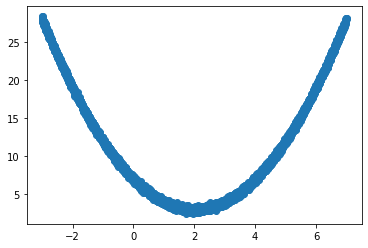

In [5]:
x = np.arange(-3, 7, 0.001)
N = np.random.normal(0, 0.2, 10000)
y = (x-2)**2+3+N
fig, ax = plt.subplots(1,1)
ax.scatter(x, y)

### Split y normalizacion de datos/

In [6]:
x_train = np.zeros((int(0.8 *len(x)),2))
x_test = np.zeros((int(0.2*len(x)),2))

print(x_train.shape)
print(x_test.shape)

(8000, 2)
(2000, 2)


In [7]:
idx = np.random.permutation(np.arange(0, 10000))

x_train[:,0] = x[idx[0:int(0.8*10000)]]
x_test[:,0] = x[idx[int(0.8*10000):]]

x_train[:,1] = x[idx[0:int(0.8*10000)]]**2
x_test[:,1] = x[idx[int(0.8*10000):]]**2

N_train = N[idx[0:int(0.8*10000)]]
N_test = N[idx[int(0.8*10000):]]

y_train = (x_train[:,0] - 2)**2 + 3 + N_train
y_test = (x_test[:,0] - 2)**2 + 3 + N_test

In [8]:
x_train[0:5,:]

array([[ 5.29    , 27.9841  ],
       [ 1.231   ,  1.515361],
       [ 0.479   ,  0.229441],
       [ 3.861   , 14.907321],
       [ 4.63    , 21.4369  ]])

In [9]:
x_train_mean = x_train.mean(axis=0)
x_train_var = x_train.var(axis=0)

x_train_norm = x_train.copy()
x_train_norm = (x_train_norm-x_train_mean)/x_train_var
x_train_norm[:5,:]

array([[ 0.39424401,  0.08223601],
       [-0.09470015, -0.05717338],
       [-0.18528552, -0.06394625],
       [ 0.22210772,  0.01336134],
       [ 0.31474089,  0.04775227]])

In [10]:
x_test_mean = x_test.mean(axis=0)
x_test_var = x_test.var(axis=0)

x_test_norm = x_test.copy()
x_test_norm = (x_test_norm-x_train_mean)/x_train_var
x_test_norm[:5,:]

array([[-0.17311913, -0.0633829 ],
       [ 0.36376781,  0.0684749 ],
       [ 0.1984977 ,  0.00559209],
       [-0.35742181, -0.06040128],
       [ 0.33871229,  0.05766645]])

In [11]:
print(np.max(x_train_norm, axis=0))
print(np.min(x_train_norm, axis=0))
print(x_train_norm)

[0.60010889 0.19285186]
[-0.6043633 -0.0651547]
[[ 0.39424401  0.08223601]
 [-0.09470015 -0.05717338]
 [-0.18528552 -0.06394625]
 ...
 [-0.31369509 -0.06333987]
 [-0.45005498 -0.04959108]
 [ 0.46001477  0.11423162]]


In [12]:
print(np.max(x_test_norm, axis=0))
print(np.min(x_test_norm, axis=0))
print(x_test_norm)

[0.59962705 0.19255703]
[-0.60400192 -0.06515469]
[[-0.17311913 -0.0633829 ]
 [ 0.36376781  0.0684749 ]
 [ 0.1984977   0.00559209]
 ...
 [ 0.12140377 -0.01695886]
 [ 0.01961569 -0.04012407]
 [ 0.13441337 -0.01345601]]


### Deep Learning

In [13]:
class CustomDataset(Dataset):
    def __init__(self, x, y):
        super().__init__()
        self.x = x
        self.y = y

    def __len__(self):
        return self.x.shape[0]
  
    def __getitem__(self, idx):
        return self.x[idx,:], self.y[idx]

In [14]:
training_set = CustomDataset(x_train_norm, y_train)

In [15]:
training_set.__len__()

8000

In [16]:
training_set.__getitem__(0)

(array([0.39424401, 0.08223601]), 13.77010005048317)

In [17]:
test_set = CustomDataset(x_test_norm, y_test)

In [18]:
test_set.__len__()

2000

In [19]:
test_set.__getitem__(0)

(array([-0.17311913, -0.0633829 ]), 5.4765581321900125)

In [20]:
training_dataloader = DataLoader(training_set, batch_size = 512, shuffle=True)
test_dataloader = DataLoader(test_set, batch_size = 256, shuffle=True)

In [33]:
# Definimos el modelo
class NNet(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.linear_1 = torch.nn.Linear(in_features = 2, out_features = 100, bias = True)
        self.dropout_1 = torch.nn.Dropout(p=0.5)
        self.relu_1 = torch.nn.ReLU()
        self.linear_2 = torch.nn.Linear(in_features = 100, out_features = 500, bias = True)
        self.dropout_2 = torch.nn.Dropout(p=0.25)
        self.relu_2 = torch.nn.ReLU()
        self.linear_3 = torch.nn.Linear(in_features = 500, out_features = 800, bias = True)
        self.dropout_3 = torch.nn.Dropout(p=0.25)
        self.relu_3 = torch.nn.ReLU()
        self.linear_4 = torch.nn.Linear(in_features = 800, out_features = 200, bias = True)
        self.dropout_4 = torch.nn.Dropout(p=0.5)
        self.relu_4 = torch.nn.ReLU()
        self.linear_5 = torch.nn.Linear(in_features = 200, out_features = 1, bias = True)
        
    def forward(self, x):
                                    
        z1 = self.linear_1(x)
        z1_1 = self.dropout_1(z1)
        a1 = self.relu_1(z1_1)
        z2 = self.linear_2(a1)
        z2_1 = self.dropout_2(z2)
        a2 = self.relu_2(z2_1)
        z3 = self.linear_3(a2)
        z3_1 = self.dropout_3(z3)
        a3 = self.relu_3(z3_1)
        z4 = self.linear_4(a3)
        z4_1 = self.dropout_4(z4)
        a4 = self.relu_4(z4_1)
        y = self.linear_5(a4)

        return y

In [34]:
nnet = NNet()

In [35]:
print(nnet)

NNet(
  (linear_1): Linear(in_features=2, out_features=100, bias=True)
  (dropout_1): Dropout(p=0.5, inplace=False)
  (relu_1): ReLU()
  (linear_2): Linear(in_features=100, out_features=500, bias=True)
  (dropout_2): Dropout(p=0.25, inplace=False)
  (relu_2): ReLU()
  (linear_3): Linear(in_features=500, out_features=800, bias=True)
  (dropout_3): Dropout(p=0.25, inplace=False)
  (relu_3): ReLU()
  (linear_4): Linear(in_features=800, out_features=200, bias=True)
  (dropout_4): Dropout(p=0.5, inplace=False)
  (relu_4): ReLU()
  (linear_5): Linear(in_features=200, out_features=1, bias=True)
)


In [36]:
criterion = torch.nn.MSELoss(reduction='mean')
optimizer = torch.optim.SGD(nnet.parameters(), lr=0.005)

In [37]:
nnet.to(device)

NNet(
  (linear_1): Linear(in_features=2, out_features=100, bias=True)
  (dropout_1): Dropout(p=0.5, inplace=False)
  (relu_1): ReLU()
  (linear_2): Linear(in_features=100, out_features=500, bias=True)
  (dropout_2): Dropout(p=0.25, inplace=False)
  (relu_2): ReLU()
  (linear_3): Linear(in_features=500, out_features=800, bias=True)
  (dropout_3): Dropout(p=0.25, inplace=False)
  (relu_3): ReLU()
  (linear_4): Linear(in_features=800, out_features=200, bias=True)
  (dropout_4): Dropout(p=0.5, inplace=False)
  (relu_4): ReLU()
  (linear_5): Linear(in_features=200, out_features=1, bias=True)
)

In [44]:
for epoch in range(100):
    running_loss = 0
    for i, data in enumerate(training_dataloader):
        # data
        x, y = data
        x = x.to(device).float()
        y = y.to(device).float().reshape(-1,1)
        
        # set gradient to zero
        optimizer.zero_grad()

        #forward
        y_hat = nnet(x).reshape(-1,1)

        #loss
        loss = criterion(y_hat, y)

        #backward
        loss.backward()

        #update of parameters
        optimizer.step()

        #compute metrics and statistics
        running_loss += loss.item()
    
    nnet.eval()
    with torch.no_grad():
        nnet_test_scores = []
        truth = []
        
        for i, data in enumerate(test_dataloader):
            #batch
            x, y = data
            x = x.to(device).float()
            y = y.to(device).float().reshape(-1,1)
        
            # forward 
            y_hat = nnet(x)
            #y_hat = torch.abs(y_hat)
        
            # accumulate data
            truth = list(y.cpu().detach().numpy()) 
            nnet_test_scores = list(y_hat.cpu().detach().numpy())
            
        mse = metrics.mean_squared_error(truth, nnet_test_scores)
        
    print(f"Epoch = {epoch} - loss = {running_loss / len(training_set)} - mse: {mse}")

Epoch = 0 - loss = 0.00010551634663715958 - mse: 0.04991092532873154
Epoch = 1 - loss = 0.00015513532282784582 - mse: 0.0904272124171257
Epoch = 2 - loss = 0.00019491899479180574 - mse: 0.15036247670650482
Epoch = 3 - loss = 0.00024733020178973675 - mse: 0.1172303855419159
Epoch = 4 - loss = 0.00026649103965610267 - mse: 0.11166049540042877
Epoch = 5 - loss = 0.00015757846971973776 - mse: 0.06531418114900589
Epoch = 6 - loss = 0.00010717794578522444 - mse: 0.04030127078294754
Epoch = 7 - loss = 0.00013293750816956162 - mse: 0.13751505315303802
Epoch = 8 - loss = 0.00017351566534489393 - mse: 0.06487400084733963
Epoch = 9 - loss = 0.0001723101884126663 - mse: 0.046631500124931335
Epoch = 10 - loss = 0.00011606304347515107 - mse: 0.07178284972906113
Epoch = 11 - loss = 0.00010108633106574416 - mse: 0.04125427454710007
Epoch = 12 - loss = 8.943736599758267e-05 - mse: 0.04804334416985512
Epoch = 13 - loss = 0.00015040082950145006 - mse: 0.06585805118083954
Epoch = 14 - loss = 0.00011553695

<p style='text-align: justify;'>
$f.$ Para el punto (e), ¿qué función de activación seleccionaste y por qué? Para la función que hayas seleccionado, explica sus características, su forward y su backward.
<p>

Para el punto e seleccione funciones de activacion tipo relu, su objetivo es aportar alinealidad a la red neuronal, esta posee ventajas a comparacion de la sigmoid evitando la posibilidad de que haya Vanishing Gradients.

Forward:
$ f(x) =
\begin{cases}
\hphantom{-}x &,\, \text{if }x\geq 0 ,\\
\hphantom{-}0 &,\, \text{if }x<0
\end{cases}$

Backward:
$ f'(x) =
\begin{cases}
\hphantom{-}1 &,\, \text{if }x\geq 0 ,\\
\hphantom{-}0 &,\, \text{if }x<0
\end{cases}$